In [129]:
import numpy as np
import tensorflow as tf
import cv2
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer graphics
from sklearn.model_selection import train_test_split
#from planet import planet
from bssfp_data_generator.planet2 import planet

In [130]:
# Function to normalize data
def normalize(data):
    data = (data - np.min(data))/(np.max(data) - np.min(data))
    return data

# Function to preprocess data for PLANET
def preprocessing(data, gt, t2):
    row = len(data[0,:,0:28][np.where(gt == t2)])
    npcs = 6
    planet_test = np.zeros((len(data)*row,npcs),dtype = complex)
    for i in range(len(data)):
        for j in range(npcs):
            planet_test[row*i:row*(i+1),j] = data[i,:,28*j:28*(j+1)][np.where(gt == t2)]
    return planet_test

# Function for Monte Carlo Simulation of PLANET
def monte_carlo(data):
    predicted_t2 = []
    TR = 3e-3 # TR = relaxation time
    npcs = 6  # npcs = no. of phase cycles, 
    B0 = 3   # B0 = main magnetic field
    alpha = np.deg2rad(30) # alpha = flip angle
    pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
    count = 0
    for i in range(len(data)): 
        _, _, temp ,_ = planet(data[i,:], alpha=alpha, TR=TR, T1_guess=2, pcs=pcs, mask=None, pc_axis=0, ret_all=False)
        if temp > 0.07 and temp < 0.12:
            predicted_t2.append(temp)
        else:
            # count number of times PLANET fails
            count = count+1 
        
    predicted_t2  = np.asarray(predicted_t2)
    return (predicted_t2, count)

In [131]:
# Load bSSFP images training data and ground truth 
img_data = np.load('c:\\Users\\yiten\\Documents\\MRI Relaxometry\\img_reg_data\\img_data.npy')
gt_data = np.load('c:\\Users\\yiten\\Documents\\MRI Relaxometry\\img_reg_data\\gt_img_data.npy')
gt_check = gt_data[0]

# Train test split
img_train, img_test, gt_train, gt_test = train_test_split(img_data, gt_data, test_size=0.1, random_state=42)

# Save complex-valued img_test for planet_test
planet_test = img_test

# Take the magnitude of img_data as training and test data
img_train = np.abs(img_train)
img_test = np.abs(img_test)

# Normalize training and test data
img_train = normalize(img_train)
img_test = normalize(img_test)

(-0.5, 167.5, 39.5, -0.5)

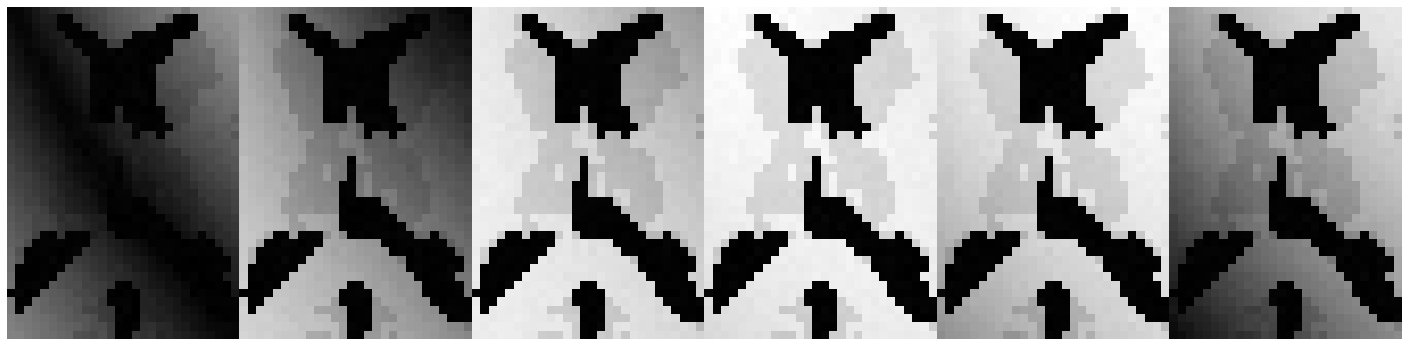

In [132]:
plt.figure(figsize=(25,8))
im = plt.imshow(img_train[2])
plt.imshow(img_train[2],cmap='gray') # greyscale
plt.axis('off')

In [133]:
def Model():

    def down_block(x, filters):
        x = tf.keras.layers.Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_uniform')(x)
        x = tf.keras.layers.Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_uniform')(x)
        x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001)(x)
        #x = Dropout(rate=0.0)(x)
        return x

    def max_pool(x):
        return tf.keras.layers.MaxPooling1D(padding="same", strides=2, pool_size=2)(x)

    def up_block(x, filters, skip_connect):
        # x = UpSampling1D(size = 2)(x)
        x = tf.keras.layers.Conv1DTranspose(filters, 3, strides=2, padding="same", activation=tf.nn.relu)(x)
        x = tf.keras.layers.concatenate([x, skip_connect], axis=2)
        x = tf.keras.layers.Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_uniform')(x)
        x = tf.keras.layers.Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_uniform')(x)
        x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001)(x)
        #x = tf.keras.layers.Dropout(rate=0.0)(x)
        return x 

    def unet():
        fn = [42, 84, 168, 336] # 6 phase cycle
        # fn = [56, 112, 224, 448] # 8 phase cycle
        fdepth = len(fn)

        x_stack = []
        xin = tf.keras.Input(shape=(img_data.shape[1],img_data.shape[2]), name='img')

        x = xin
        for idx in range(fdepth):
            x = down_block(x, fn[idx])

            if(idx < fdepth - 1):
                x_stack.append(x)
                x = max_pool(x)

        for idx in range(fdepth - 1):
            idx = fdepth - idx - 2
            x = up_block(x, fn[idx], x_stack.pop())

        xout = tf.keras.layers.Conv1D(gt_data.shape[2], 1, padding="same", activation='linear')(x)
        return tf.keras.Model(inputs=xin, outputs=xout)

    return unet()

In [1]:
# Setup Unet model
model = Model()
model.summary()

NameError: name 'Model' is not defined

In [135]:
# Define optimizer and train the network
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics='mse')
start=time.time()

# Starts training
history = model.fit(img_train, gt_train, epochs=30, batch_size=10, validation_split=0.1)  
end=time.time()
print('Time Elapsed:%i seconds'%(end-start))

Epoch 1/30
81/81 [==============================] - 3s 33ms/step - loss: 0.1543 - mse: 0.1543 - val_loss: 0.0166 - val_mse: 0.0166
Epoch 2/30
81/81 [==============================] - 2s 24ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 3/30
81/81 [==============================] - 2s 23ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 4/30
81/81 [==============================] - 2s 23ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 5/30
81/81 [==============================] - 2s 22ms/step - loss: 8.0441e-04 - mse: 8.0441e-04 - val_loss: 7.5907e-04 - val_mse: 7.5907e-04
Epoch 6/30
81/81 [==============================] - 2s 23ms/step - loss: 6.1264e-04 - mse: 6.1264e-04 - val_loss: 6.0462e-04 - val_mse: 6.0462e-04
Epoch 7/30
81/81 [==============================] - 2s 23ms/step - loss: 4.9806e-04 - mse: 4.9806e-04 - val_loss: 4.9243e-04 - val_mse: 4.9243e-04
Epoch 8/30
81/81 [=================

In [136]:
# Save or load trained model 
#model.save('image_regression'); 
#model = tf.keras.models.load_model('image_regression')

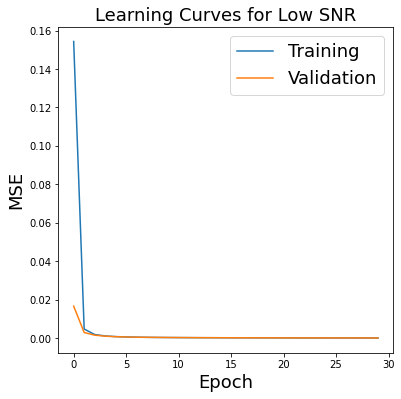

10/10 [==============================] - 0s 10ms/step - loss: 9.1988e-05 - mse: 9.1988e-05
Test MSE:0.000092


In [137]:
# Learning Curve
# MSE for each epoch during training
#print(model.summary())
#print(history.history.keys())
fs = 18
plt.figure(figsize=(6,6))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Learning Curves for Low SNR',fontsize=fs)
plt.ylabel('MSE',fontsize=fs)
plt.xlabel('Epoch',fontsize=fs)
plt.legend(['Training', 'Validation'], loc='upper right',fontsize=fs)
plt.show()

# Evaluate model using testing set
test_metric = model.evaluate(img_test, gt_test, batch_size=10)
print('Test MSE:%.6f'%test_metric[1])

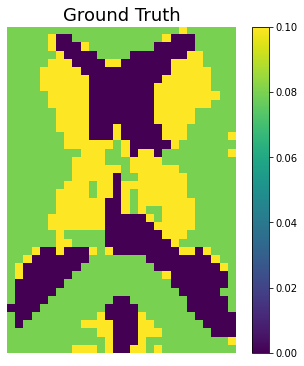

In [138]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
im = ax1.imshow(gt_test[0])
ax1.axis('off')
ax1.set_title('Ground Truth',fontsize=fs)
plt.colorbar(im,ax=ax1)
# Gray Matter (100ms) in yellow
# White Matter (80ms) in green

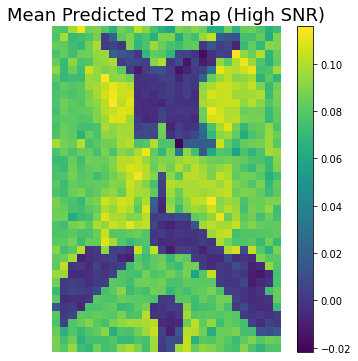

In [139]:
predicted_t2map = model.predict(img_test)
fig, ax2 = plt.subplots(1, 1, figsize=(6, 6))
im = ax2.imshow(predicted_t2map.mean(axis=0))
ax2.axis('off')
ax2.set_title('Mean Predicted T2 map (High SNR)',fontsize=fs)
plt.colorbar(im,ax=ax2)

In [140]:
# Split predicted data into gray and white matter
predicted_gm_t2 = []
predicted_wm_t2 = []
for i in range(len(predicted_t2map)):
    predicted_gm_t2.extend(predicted_t2map[i][np.where(gt_check == 0.1)])
    predicted_wm_t2.extend(predicted_t2map[i][np.where(gt_check == 0.08)])

print(len(predicted_gm_t2))
print(len(predicted_wm_t2))

27600
56000


In [141]:
# PLANET : Monte Carlo
planet_gm_test = preprocessing(planet_test,gt_check,0.1)
planet_wm_test = preprocessing(planet_test,gt_check,0.08)
print(planet_gm_test.shape)
print(planet_wm_test.shape)

gm_pdf_p, count_failed_gm = monte_carlo(planet_gm_test)
print('Rejected %d out of %d' %(count_failed_gm,len(planet_gm_test)))
print('PLANET Mean T2 (GM):', gm_pdf_p.mean())

wm_pdf_p, count_failed_wm = monte_carlo(planet_wm_test)
print('Rejected %d out of %d' %(count_failed_wm,len(planet_wm_test)))
print('PLANET Mean T2 (WM):', wm_pdf_p.mean())

(27600, 6)
(56000, 6)
Rejected 15224 out of 27600
PLANET Mean T2 (GM): 0.09253799171374595
Rejected 24902 out of 56000
PLANET Mean T2 (WM): 0.08894059438659649


In [142]:
# Histograms
# Parameters for histograms plotting
snr_data = np.load('c:\\Users\\yiten\\Documents\\MRI Relaxometry\\img_reg_data\\snr_img_data.npy')
s = '\n'
gm_str = s.join(['$\mu_{nn} = %.2f ms, \sigma_{nn} = %.2f ms$'%(np.mean(predicted_gm_t2)*1000,np.std(predicted_gm_t2)*1000), '$\mu_{p}  = %.2f ms, \sigma_{p}  = %.2f ms$'%(gm_pdf_p.mean()*1000,gm_pdf_p.std()*1000)])
wm_str = s.join(['$\mu_{nn} = %.2f ms, \sigma_{nn}  = %.2f ms$'%(np.mean(predicted_wm_t2)*1000,np.std(predicted_wm_t2)*1000), '$\mu_{p}  = %.2f ms, \sigma_{p}  = %.2f ms$'%(wm_pdf_p.mean()*1000,wm_pdf_p.std()*1000)])
textbox_height = 0.9
textbox_width  = 0.55
fs = 18
bins = 20
bins_p = 20

<ipython-input-143-ae22159449fd>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(ax1.get_yticks()/100, fontsize = 15)
<ipython-input-143-ae22159449fd>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(np.round(ax1.get_xticks()*1000,1), fontsize = 15)


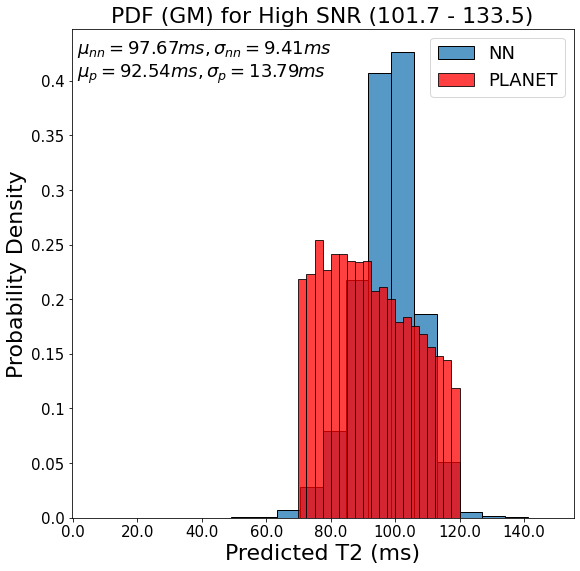

In [143]:
# GM
fig, ax1 = plt.subplots(1, 1, figsize=(9, 9))
sns.histplot(data=predicted_gm_t2, bins=bins, stat='density', legend=False, label='NN', ax=ax1)
sns.histplot(data=gm_pdf_p, bins=bins_p, stat='density', legend=False, label='PLANET',color='r', ax=ax1)
ax1.set_title('PDF (GM) for High SNR (%.1f - %.1f)'%(snr_data[0],snr_data[1]),fontsize=22)
ax1.text(textbox_width-0.54, textbox_height,gm_str,fontsize=fs,transform=ax1.transAxes)
ax1.set_xlabel('Predicted T2 (ms)',fontsize=22)
ax1.set_ylabel('Probability Density',fontsize=22)
ax1.set_yticklabels(ax1.get_yticks()/100, fontsize = 15)
ax1.set_xticklabels(np.round(ax1.get_xticks()*1000,1), fontsize = 15)
ax1.legend(fontsize=fs)

<ipython-input-145-14eaca178a35>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks()/100, fontsize = 15)
<ipython-input-145-14eaca178a35>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(np.round(ax2.get_xticks()*1000,1), fontsize = 15)


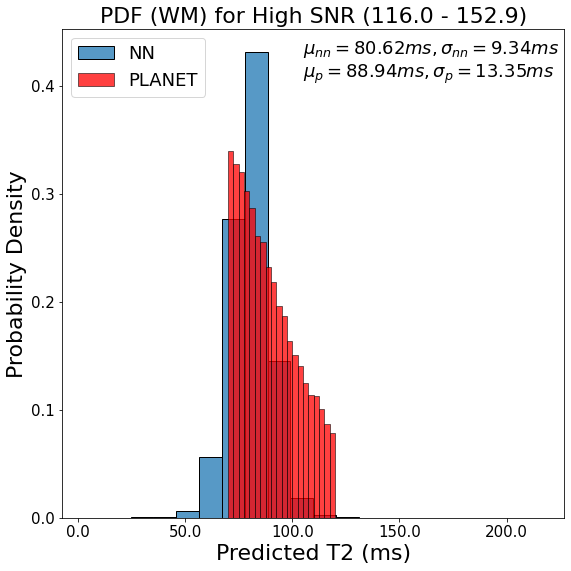

In [145]:
# WM
fig, ax2 = plt.subplots(1, 1, figsize=(9, 9))
sns.histplot(data=predicted_wm_t2, bins=bins, stat='density', legend=False, label='NN',ax=ax2)
sns.histplot(data=wm_pdf_p, bins=bins_p, stat='density', legend=False, label='PLANET',color='r', ax=ax2)
ax2.set_title('PDF (WM) for High SNR (%.1f - %.1f)'%(snr_data[2],snr_data[3]),fontsize=22)
ax2.text(textbox_width-0.07, textbox_height,wm_str,fontsize=fs,transform=ax2.transAxes)
ax2.set_xlabel('Predicted T2 (ms)',fontsize=22)
ax2.set_ylabel('Probability Density',fontsize=22)
ax2.set_yticklabels(ax2.get_yticks()/100, fontsize = 15)
ax2.set_xticklabels(np.round(ax2.get_xticks()*1000,1), fontsize = 15)
ax2.legend(loc='upper left',fontsize=fs)